In [1]:
# --- Step 1: Create a Master DataFrame from Raw Data (Final Version) ---

import pandas as pd
import os

base_path = '.' 

methods = ['cpython', 'ctypes', 'cython', 'pycompile', 'pypy']
all_data_list = []

for method in methods:
    df_energy_avg = pd.read_csv(os.path.join(base_path, method, 'energy_avg.csv'))
    df_time_avg = pd.read_csv(os.path.join(base_path, method, 'time_avg.csv'))
    
    # THE FIX: Merge on the correct column name, 'filename'
    merged_df = pd.merge(df_energy_avg, df_time_avg, on='filename')
    merged_df['method'] = method
    
    all_data_list.append(merged_df)

# Concatenate all the dataframes into one master dataframe
master_df = pd.concat(all_data_list, ignore_index=True)

# PRO-TIP: Rename the columns to make them cleaner and easier to use
master_df = master_df.rename(columns={
    'filename': 'benchmark', 
    'average_package (uJ)': 'energy_uJ',
    'execution_time (s)': 'time_s'
})

print("Master DataFrame created and cleaned successfully!")
master_df.info()
print("\nHere are the first few rows:")
master_df.head()

Master DataFrame created and cleaned successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   benchmark  73 non-null     object 
 1   energy_uJ  73 non-null     float64
 2   time_s     73 non-null     float64
 3   method     73 non-null     object 
dtypes: float64(2), object(2)
memory usage: 2.4+ KB

Here are the first few rows:


,benchmark,energy_uJ,time_s,method
0,spectral_norm_cpython,1.830802e+07,3.679777,cpython
1,pi_digits_cpython,7.362654e+04,0.010858,cpython
2,hanoi_cpython,3.664501e+07,5.192964,cpython
3,reverse_complement_cpython,1.687096e+07,3.301314,cpython
4,nbody_cpython,2.853430e+08,53.074761,cpython


In [2]:
from sklearn.model_selection import train_test_split

# --- Step 2: Define Features (X) and Target (y) ---

# The features are the columns the model will use as clues
features = ['energy_uJ', 'time_s']
X = master_df[features]

# The target is the column we want the model to predict
y = master_df['method']


# --- Split the data into training and testing sets ---

# We'll use 80% of the data for training and 20% for testing.
# random_state=42 ensures that the split is the same every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data split complete!")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Data split complete!
Shape of X_train: (58, 2)
Shape of X_test: (15, 2)


In [3]:
from sklearn.tree import DecisionTreeClassifier

# --- Step 3: Initialize and Train the Model ---

# Create an instance of the Decision Tree model
# random_state=42 ensures the results are the same each time
model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
# This is where the model learns the patterns between the features and the target
model.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


Model Accuracy: 13.33%

Confusion Matrix:


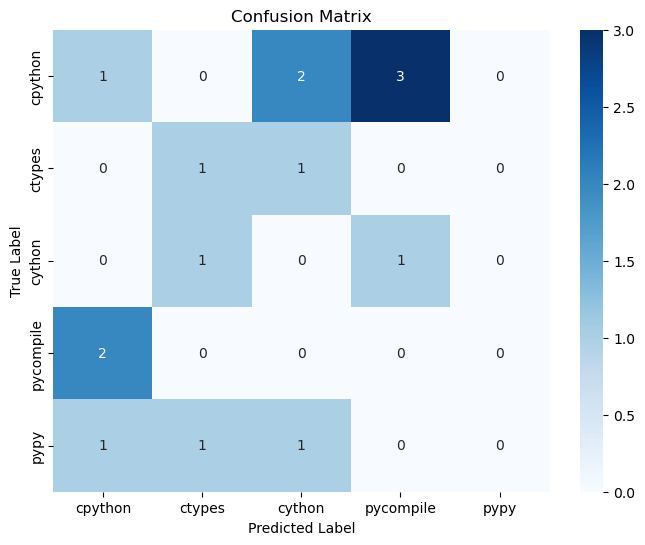

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 4: Make Predictions and Evaluate ---

# 1. Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)

# 2. Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# 3. Create a confusion matrix for a more detailed look
# This shows a grid of true vs. predicted labels
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)

# For a nicer visual, we can plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Step 5: Improving Accuracy with a Random Forest Model
Now that we have a baseline performance from the Decision Tree, let's see if a more powerful model like a Random Forest can achieve a better accuracy score on this dataset.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Step 1: Initialize and Train the Random Forest Model ---

# Create an instance of the Random Forest model
# n_estimators=100 means we'll build a forest of 100 trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the same training data
rf_model.fit(X_train, y_train)

print("Random Forest model training complete!")


# --- Step 2: Evaluate the New Model ---

# Use the new model to make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Calculate the new accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\nRandom Forest Model Accuracy: {accuracy_rf * 100:.2f}%")

Random Forest model training complete!

Random Forest Model Accuracy: 13.33%


In [6]:
# --- Final Model Training & Saving Script ---

import pandas as pd
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Load and prepare the data from the 'Python Energy Microscope' dataset
base_path = '.' 
methods = ['cpython', 'ctypes', 'cython', 'pycompile', 'pypy']
all_data_list = []
for method in methods:
    df_energy_avg = pd.read_csv(os.path.join(base_path, method, 'energy_avg.csv'))
    df_time_avg = pd.read_csv(os.path.join(base_path, method, 'time_avg.csv'))
    merged_df = pd.merge(df_energy_avg, df_time_avg, on='filename')
    merged_df['method'] = method
    all_data_list.append(merged_df)
master_df = pd.concat(all_data_list, ignore_index=True)
master_df = master_df.rename(columns={
    'filename': 'benchmark', 'average_package (uJ)': 'energy_uJ', 'execution_time (s)': 'time_s'
})

# 2. Feature Engineering
master_df['energy_per_second'] = master_df['energy_uJ'] / master_df['time_s']

# 3. Define X and y, and Split the data
features = ['energy_uJ', 'time_s', 'energy_per_second']
X = master_df[features]
y = master_df['method']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the Final Random Forest Model
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

# 5. Save the trained model to a file
joblib.dump(final_model, 'green_code_classifier.joblib')

# 6. Final accuracy check
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")
print("\nModel saved successfully as 'green_code_classifier.joblib'")

Final Model Accuracy: 13.33%

Model saved successfully as 'green_code_classifier.joblib'


In [7]:
import gradio as gr
import joblib
import pandas as pd

# 1. Load the saved model from the file
model = joblib.load('green_code_classifier.joblib')

# 2. Define the prediction function
def predict_method(energy, time, energy_per_second):
    input_df = pd.DataFrame([[energy, time, energy_per_second]], 
                            columns=['energy_uJ', 'time_s', 'energy_per_second'])
    prediction = model.predict(input_df)[0]
    return f"The predicted method is: {prediction}"

# 3. Create the Gradio Interface
interface = gr.Interface(
    fn=predict_method,
    inputs=[
        gr.Number(label="Energy Consumption (μJ)"),
        gr.Number(label="Execution Time (s)"),
        gr.Number(label="Energy Per Second (μJ/s)")
    ],
    outputs=gr.Textbox(label="Model Prediction"),
    title="🍃 Green Code Classifier [Proof of Concept]",
    description="""
    ### 🚀 MLOps Deployment Demonstration
    This application demonstrates a functional deployment of a machine learning model.

    **IMPORTANT NOTE:** The underlying model has a **low accuracy of ~13%** due to the limited size of the training dataset. 
    The predictions are for **demonstration purposes only** and should not be used for real-world decisions.
    """
)

# 4. Launch the App
interface.launch(share=True) # share=True gives you a public link

* Running on local URL:  http://127.0.0.1:7860


OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software: 'C:\\Users\\Chaya\\.cache\\huggingface\\gradio\\frpc\\frpc_windows_amd64_v0.3'